[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/nbs/10a_tutorial_medmnist_classification.ipynb)

In [ ]:
#| hide
#Install `fastMONAI` if notebook is running on Google Colab
try:
    import google.colab
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()
except:
    print('Running locally')

Running locally


## Beginner

The following line imports all of the functions and classes from the fastMONAI library: 

In [ ]:
from fastMONAI.vision_all import *

### Downloading external data

To demonstrate the use of fastMONAI, we download the NoduleMNIST3D dataset from MedMNIST v2 [@yang2023medmnist], a dataset containing lung nodules with labels indicating whether the nodules are benign (b) or malignant (m): 

In [ ]:
df, _ = download_medmnist3d_dataset(study='NoduleMNIST3D', max_workers = 8)

NoduleMNIST3D.npz: 27.9MB [00:31, 943kB/s]                             

2023-07-14 15:35:47,615 - INFO - Downloaded: ../data/NoduleMNIST3D/NoduleMNIST3D.npz
2023-07-14 15:35:47,616 - INFO - Expected md5 is None, skip md5 check for file ../data/NoduleMNIST3D/NoduleMNIST3D.npz.


### Inspecting the data

Let's look at how the processed DataFrame is formatted:

In [ ]:
df.head()

,img_path,labels,is_val
0,../data/NoduleMNIST3D/train_images/0_nodule.nii.gz,0,False
1,../data/NoduleMNIST3D/train_images/1_nodule.nii.gz,1,False
2,../data/NoduleMNIST3D/train_images/2_nodule.nii.gz,1,False
3,../data/NoduleMNIST3D/train_images/3_nodule.nii.gz,0,False
4,../data/NoduleMNIST3D/train_images/4_nodule.nii.gz,0,False


In fastMONAI, various data augmentation techniques are available for training vision models, and they can also optionally be applied during inference. The following code cell specifies a list of transformations to be applied to the items in the training set. The complete list of available transformations in the library can be found at [https://fastmonai.no/vision_augment](https://fastmonai.no/vision_augment).

In [ ]:
item_tfms = [PadOrCrop(size = 28), RandomAffine(degrees = 35, isotropic = True), ZNormalization()]

Before feeding the data into a model, we must create a `DataLoaders` object for our dataset. There are several ways to get the data in `DataLoaders`. 
In the following line, we call the ` ImageDataLoaders.from_df` factory method, which is the most basic way of building a `DataLoaders`. 

Here, we pass the processed DataFrame, define the columns for the images `fn_col` and the labels `label_col`, some transforms `item_tfms`, voxel spacing `resample`, and the batch size `bs`. 

In [ ]:
dls = MedImageDataLoaders.from_df(df, fn_col = 'img_path', label_col = 'labels', 
                                  item_tfms = item_tfms, resample = 1, bs = 64)

We can now take a look at a batch of images in the training set using `show_batch` :

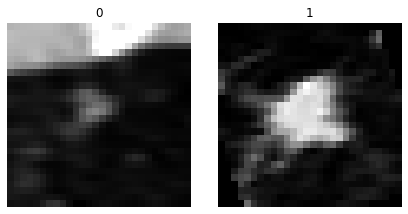

In [ ]:
dls.show_batch(max_n = 2, anatomical_plane = 2)

### Choosing a loss function

_Class imbalance_ is a common challenge in medical datasets, and it is something we're facing in our example dataset:

In [ ]:
print(df.labels.value_counts())

labels
0    986
1    337
Name: count, dtype: int64


There are multiple ways to deal with class imbalance. A straightforward technique is to use balancing weights in the model's loss function, i.e., penalizing misclassifications for instances belonging to the minority class more heavily than those of the majority class. 

In [ ]:
train_labels = df.loc[~df.is_val]['labels'].tolist()
class_weights = get_class_weights(train_labels)
print(class_weights)

tensor([0.6709, 1.9627])


In [ ]:
loss_func = CrossEntropyLossFlat(weight = class_weights)

We're now ready to construct a deep learning classification model. 

### Create and train a 3D deep learning model

We import a classification network from MONAI and configure it based on our task, including defining the input image size, the number of classes to predict, channels, etc.  

In [ ]:
from monai.networks.nets import Classifier

model = Classifier(in_shape = [1, 28, 28, 28], classes = 2, 
                   channels = (8, 16, 32, 64), strides = (2, 2, 2))

Then we create a `Learner`, which is a fastai object that combines the data and our defined model for training.

In [ ]:
learn = Learner(dls, model,loss_func = loss_func, metrics = accuracy)

In [ ]:
learn.fit_one_cycle(4) 

epoch,train_loss,valid_loss,accuracy,time
0,0.570975,0.483218,0.746212,00:06
1,0.520343,0.408349,0.859848,00:06
2,0.461724,0.410592,0.867424,00:05
3,0.424535,0.422911,0.814394,00:05


**Note:** Small random variations are involved in training CNN models. Hence, when running the notebook, you may see different results.

With the model trained, let's look at some predictions on the validation data. The `show_results` method plots instances, their target values, and their corresponding predictions from the model.

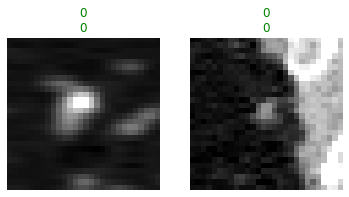

In [ ]:
learn.show_results(max_n = 2, anatomical_plane = 2) 

### Model evaluation and interpretation

Let's look at how often and for what instances our trained model becomes confused while making predictions on the validation data:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

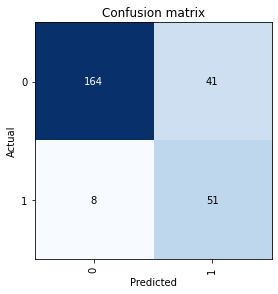

In [ ]:
cm = interp.plot_confusion_matrix()

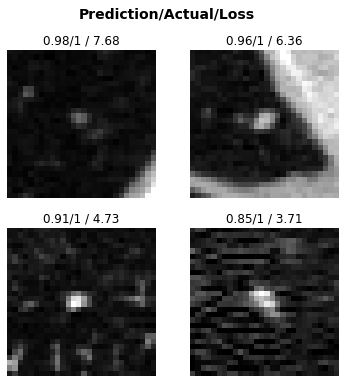

In [ ]:
interp.plot_top_losses(k=4, anatomical_plane=2) 